In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amazon-employee-access-challenge/sampleSubmission.csv
/kaggle/input/amazon-employee-access-challenge/train.csv
/kaggle/input/amazon-employee-access-challenge/test.csv


In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import copy

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import (StratifiedKFold, train_test_split, 
                                     RandomizedSearchCV, GridSearchCV)
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

from sklearn import pipeline

import optuna
from functools import partial

In [3]:
train = pd.read_csv('../input/amazon-employee-access-challenge/train.csv')
test = pd.read_csv('../input/amazon-employee-access-challenge/test.csv')

In [4]:
train

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880
3,1,36135,5396,117961,118343,119993,118321,240983,290919,118322
4,1,42680,5905,117929,117930,119569,119323,123932,19793,119325
...,...,...,...,...,...,...,...,...,...,...
32764,1,23497,16971,117961,118300,119993,118321,240983,290919,118322
32765,1,25139,311198,91261,118026,122392,121143,173805,249618,121145
32766,1,34924,28805,117961,118327,120299,124922,152038,118612,124924
32767,1,80574,55643,118256,118257,117945,280788,280788,292795,119082


In [5]:
train.dtypes

ACTION              int64
RESOURCE            int64
MGR_ID              int64
ROLE_ROLLUP_1       int64
ROLE_ROLLUP_2       int64
ROLE_DEPTNAME       int64
ROLE_TITLE          int64
ROLE_FAMILY_DESC    int64
ROLE_FAMILY         int64
ROLE_CODE           int64
dtype: object

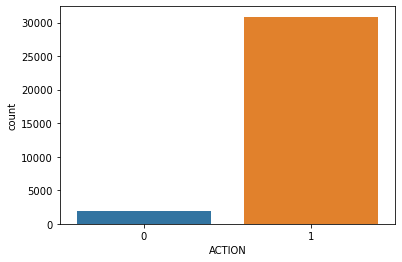

In [6]:
sns.countplot(train['ACTION'])

In [7]:
train['RESOURCE'].value_counts().sort_values(ascending=False)

4675     839
79092    484
25993    409
75078    409
3853     404
        ... 
32243      1
86126      1
16780      1
36173      1
75934      1
Name: RESOURCE, Length: 7518, dtype: int64

In [8]:
for i in train.columns:
    Mean_encoded_subject = train.groupby([i])['ACTION'].mean().to_dict() 
    train[i] =  train[i].map(Mean_encoded_subject)
    
    if i!='ACTION':
        test[i] =  test[i].map(Mean_encoded_subject)
    
test

,id,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,1.000000,0.800000,0.809955,0.809955,0.937445,0.889331,0.719298,0.907815,0.889331
1,2,0.500000,1.000000,0.949222,0.954563,0.943820,0.991736,1.000000,0.952087,0.991736
2,3,1.000000,1.000000,0.949222,0.956148,1.000000,0.937500,0.948052,0.977679,0.937500
3,4,1.000000,0.866667,0.949222,0.957205,0.979323,0.913495,1.000000,0.941935,0.913495
4,5,0.941176,1.000000,0.949222,0.969075,0.977901,0.992021,1.000000,0.972491,0.992021
...,...,...,...,...,...,...,...,...,...,...
58916,58917,0.990220,0.956522,0.949222,0.912584,0.992188,0.929458,0.933440,0.942350,0.929458
58917,58918,0.946488,0.814815,0.949222,0.957205,0.891304,0.970284,0.980707,0.959167,0.970284
58918,58919,0.961240,1.000000,0.949222,0.969075,0.884615,0.979592,0.984925,0.942350,0.979592
58919,58920,0.882353,1.000000,0.949222,0.954563,0.884058,0.920413,0.933440,0.942350,0.920413


In [9]:
train['ACTION']=train['ACTION'].astype('float64')

In [10]:
X=train.drop(columns='ACTION').to_numpy()
y=train['ACTION'].to_numpy()

In [11]:
train = train.astype({"ACTION":'int64'})

In [12]:
train.dtypes

ACTION                int64
RESOURCE            float64
MGR_ID              float64
ROLE_ROLLUP_1       float64
ROLE_ROLLUP_2       float64
ROLE_DEPTNAME       float64
ROLE_TITLE          float64
ROLE_FAMILY_DESC    float64
ROLE_FAMILY         float64
ROLE_CODE           float64
dtype: object

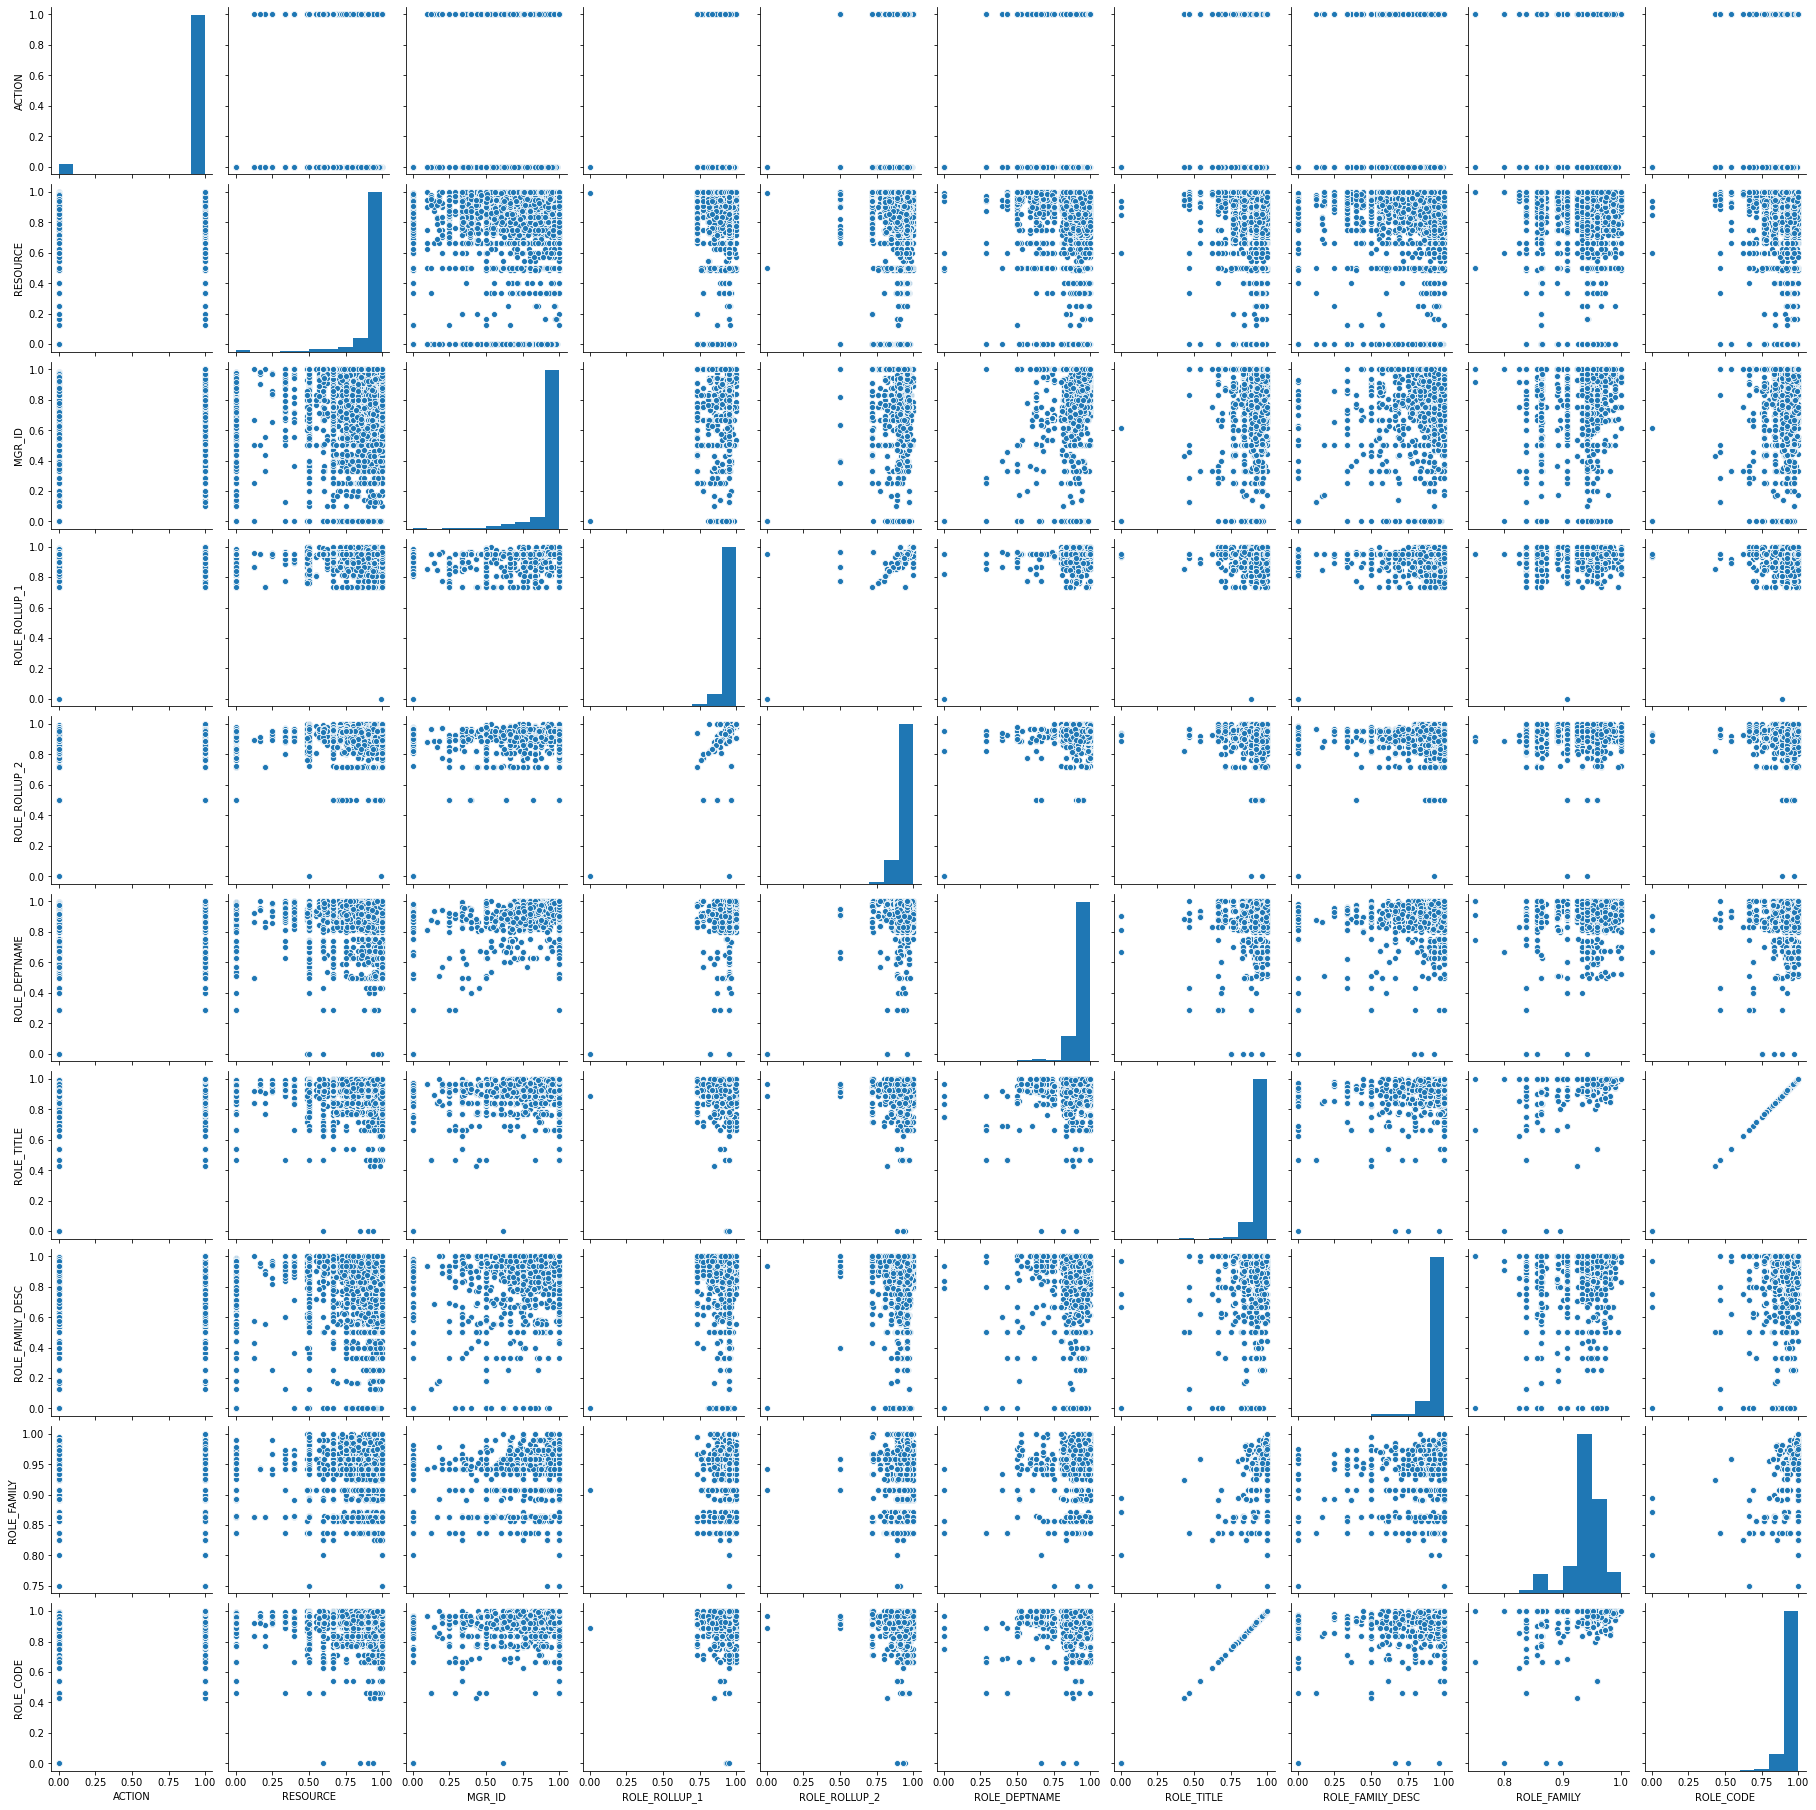

In [13]:
sns.pairplot(data=train, kind='scatter')

In [14]:
train_corr=train.corr()
train_corr['ACTION'].sort_values(ascending=False)

ACTION              1.000000
MGR_ID              0.579282
RESOURCE            0.568624
ROLE_FAMILY_DESC    0.401364
ROLE_DEPTNAME       0.288879
ROLE_CODE           0.208369
ROLE_TITLE          0.208369
ROLE_ROLLUP_2       0.189294
ROLE_ROLLUP_1       0.152602
ROLE_FAMILY         0.130232
Name: ACTION, dtype: float64

In [15]:
train=train.drop(columns='ROLE_TITLE')
test=test.drop(columns='ROLE_TITLE')

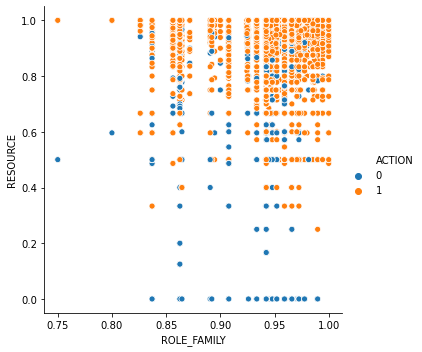

In [16]:
sns.relplot(data=train, x="ROLE_FAMILY", y="RESOURCE", hue="ACTION")

In [17]:
train.columns

Index(['ACTION', 'RESOURCE', 'MGR_ID', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2',
       'ROLE_DEPTNAME', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY', 'ROLE_CODE'],
      dtype='object')

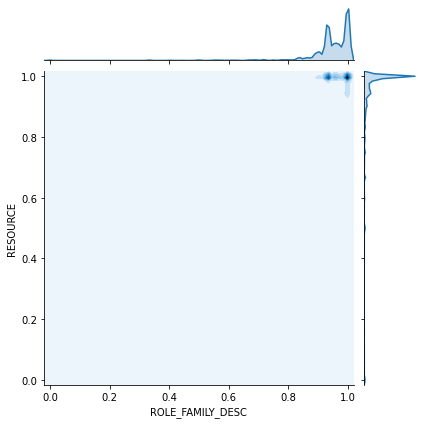

In [18]:
#train = train.astype({"ACTION":'O'})
sns.jointplot(data=train, x="ROLE_FAMILY_DESC", y="RESOURCE", kind="kde")

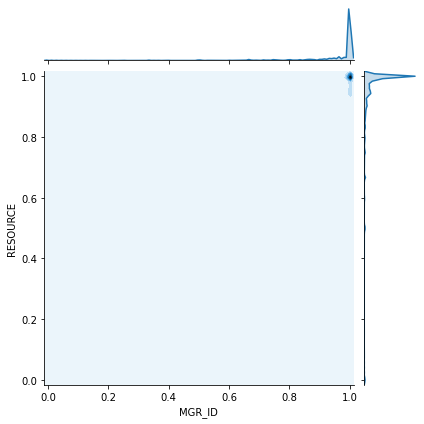

In [19]:
sns.jointplot(x='MGR_ID', y='RESOURCE', data=train, kind='kde')

In [20]:
train

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,1.000000,1.000000,0.949222,0.956148,0.958333,0.933440,0.942350,0.967625
1,1,0.966667,1.000000,0.949222,0.969075,0.893082,1.000000,0.947941,0.962963
2,1,1.000000,1.000000,0.918478,0.918478,0.923077,0.939394,0.907815,0.889331
3,1,1.000000,1.000000,0.949222,0.969075,0.989474,0.955788,0.942350,0.920413
4,1,1.000000,1.000000,0.931159,0.876812,0.755556,0.947368,0.837017,0.866667
...,...,...,...,...,...,...,...,...,...
32764,1,0.901961,0.965517,0.949222,0.956148,0.989474,0.955788,0.942350,0.920413
32765,1,1.000000,1.000000,0.963939,0.963939,1.000000,1.000000,0.977679,1.000000
32766,1,0.962733,1.000000,0.949222,0.954563,1.000000,1.000000,0.974359,1.000000
32767,1,1.000000,0.687500,0.734545,0.719844,0.864947,0.860656,0.862671,0.913706


In [21]:
corr_matrix=train.corr()
corr_matrix['ACTION']

ACTION              1.000000
RESOURCE            0.568624
MGR_ID              0.579282
ROLE_ROLLUP_1       0.152602
ROLE_ROLLUP_2       0.189294
ROLE_DEPTNAME       0.288879
ROLE_FAMILY_DESC    0.401364
ROLE_FAMILY         0.130232
ROLE_CODE           0.208369
Name: ACTION, dtype: float64

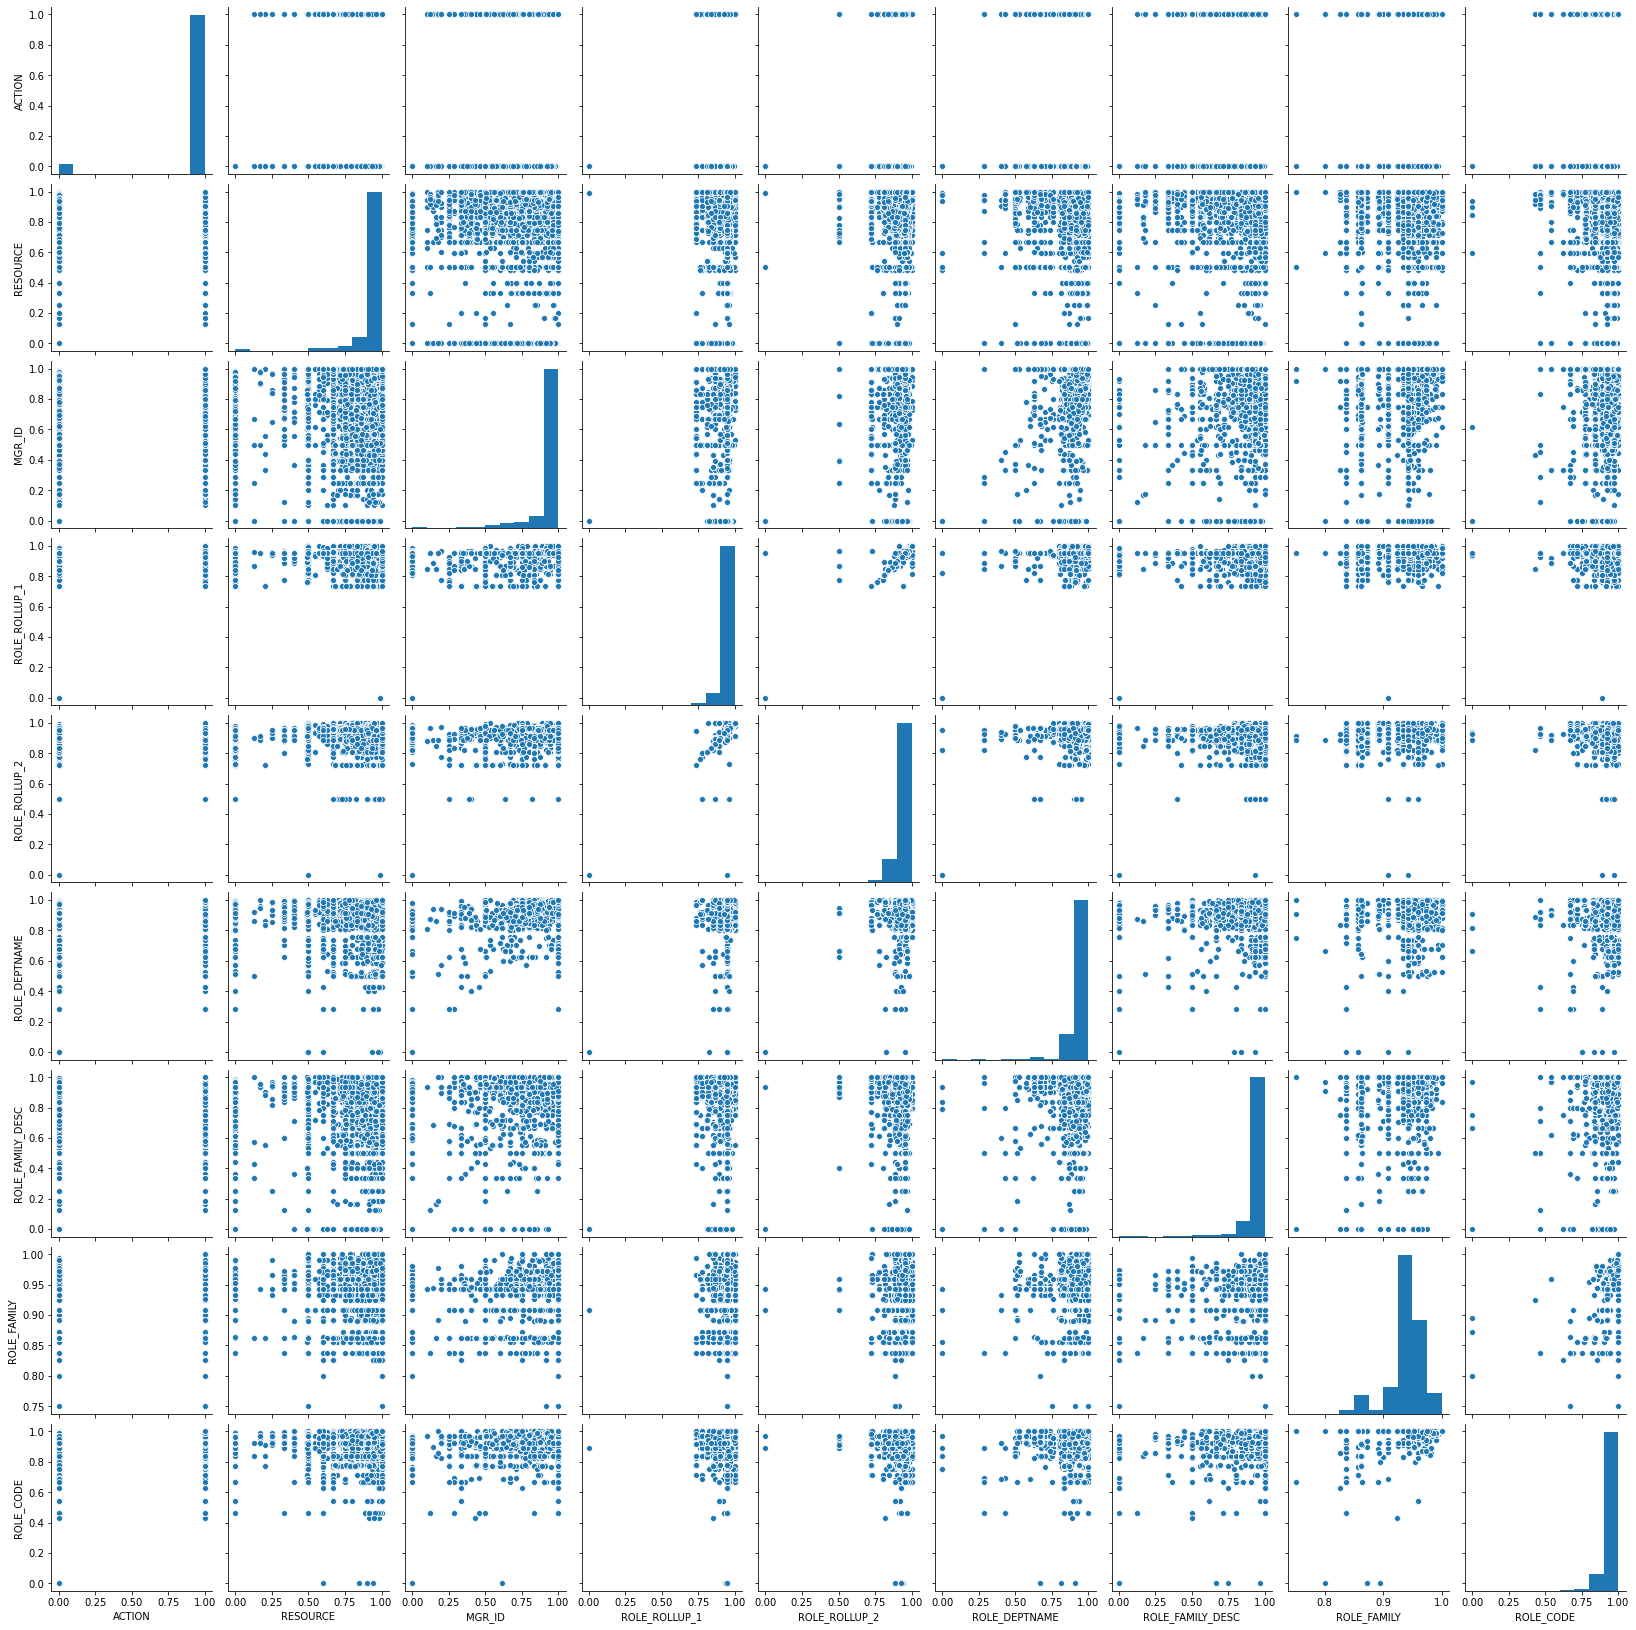

In [22]:
sns.pairplot(data=train, kind='scatter')

In [23]:
train['ACTION'].value_counts()

1    30872
0     1897
Name: ACTION, dtype: int64

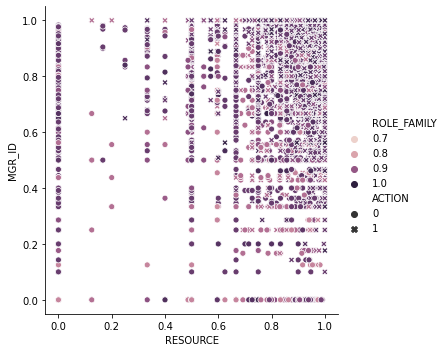

In [24]:
sns.relplot(data=train,
            x="RESOURCE", 
            y="MGR_ID",
            hue="ROLE_FAMILY",
            #size="ROLE_FAMILY",
            style="ACTION",
            kind="scatter")

In [28]:
l_enc = LabelEncoder()
X=train.drop(columns='ACTION').to_numpy()
y=train['ACTION'].to_numpy()
y = l_enc.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, stratify=y)

trained= pd.DataFrame(X_train)
trained.columns= train.columns[1:]

def jittered(arr):
    stdev = .01 * (max(arr) - min(arr))
    jit = arr + np.random.randn(len(arr)) * stdev
    #transformed=stats.boxcox(jit +abs(np.min(jit))+0.1)[0]
    
    return jit

for i in train.columns[1:]:
    trained[i] = jittered(trained[i])
    
X_train=trained.to_numpy()
trained

,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,0.978297,1.011859,0.889856,0.903116,0.936333,1.001008,0.908417,0.931310
1,0.808112,1.019916,0.880196,0.892287,1.000432,0.996019,0.974738,0.943527
2,0.764336,0.984996,0.950013,0.967364,0.982011,0.937119,0.941108,0.896649
3,0.997904,0.945469,0.945580,0.964267,0.973852,1.007557,0.990755,0.994699
4,0.986764,0.944187,0.827135,0.847884,0.903633,0.820578,0.907703,0.927155
...,...,...,...,...,...,...,...,...
24571,1.000246,0.999393,0.953611,0.913527,0.938031,1.012388,0.971216,0.985001
24572,0.945541,1.000354,0.919799,0.975124,1.008423,0.891627,0.969214,0.943322
24573,0.992015,0.776320,0.958926,0.956079,0.910392,0.935760,0.945703,0.925008
24574,0.997709,1.003148,0.944850,0.932248,0.990879,0.990662,0.990667,1.008439


In [29]:
xgb=XGBClassifier(subsample=0.1)

classifier= pipeline.Pipeline([("xgb",xgb)])

param_grid={
    "xgb__n_estimators":np.arange(100,1500,100),
    "xgb__max_depth": np.arange(3,11,2),
    "xgb__learning_rate": np.arange(0.001,0.1)
}

random_search= RandomizedSearchCV(estimator=classifier,
                         param_distributions=param_grid,
                         scoring='roc_auc',
                         verbose=10,
                         n_iter=100,
                         n_jobs=-1,
                         cv=5)

random_search.fit(X_train,y_train)

print(random_search.best_score_, random_search.best_estimator_.get_params())

Fitting 5 folds for each of 56 candidates, totalling 280 fits


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:282: UserWarning: The total space of parameters 56 is smaller than n_iter=100. Running 56 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   40.1s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 105

0.9828853950475978 {'memory': None, 'steps': [('xgb', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.001, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1400, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.1,
              tree_method='exact', validate_parameters=1, verbosity=None))], 'verbose': False, 'xgb': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.001, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=nan, monotone_constrai

In [30]:
test=test.drop(columns='id')
X=test.to_numpy()

In [31]:
model=XGBClassifier(n_estimators=1400,max_depth= 7,
                        learning_rate=0.001, subsample=0.1)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
fold_auc = roc_auc_score(y_test, y_pred)
fold_auc

0.8525424687725998

In [32]:
predictions= model.predict_proba(X)

In [33]:
sub=pd.read_csv("../input/amazon-employee-access-challenge/sampleSubmission.csv")
sub.Id=np.arange(1,len(test)+1)
sub.Action=predictions[:,1]

sub

,Id,Action
0,1,0.842503
1,2,0.842749
2,3,0.874749
3,4,0.861962
4,5,0.874739
...,...,...
58916,58917,0.873721
58917,58918,0.820948
58918,58919,0.874749
58919,58920,0.874610


In [34]:
sub.to_csv('amazon_xgboost_submission.csv', index=False, header=True)
sub.head()

,Id,Action
0,1,0.842503
1,2,0.842749
2,3,0.874749
3,4,0.861962
4,5,0.874739
